In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.10.0
sys.version_info(major=3, minor=10, micro=5, releaselevel='final', serial=0)
matplotlib 3.8.0
numpy 1.24.1
pandas 2.1.2
sklearn 1.3.2
tensorflow 2.10.0
keras.api._v2.keras 2.10.0


1. loads data
2. preprocesses data -> dataset
3. tools
    - generates position embedding
    - create mask. (a. padding, b. decoder)
    - scaled_dot_product_attention
4. builds model 分为以下6步
    - MultiheadAttention
    - EncoderLayer
    - DecoderLayer
    - EncoderModel
    - DecoderModel
    - Transformer
5. optimizer & loss
6. train step -> train
7. Evaluate and Visualize

In [2]:
import tensorflow_datasets as tfds
# 葡萄牙语Portugal -> 英语English，基于subword_level
examples, info = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)

print(type(examples)) # <class 'dict'>, 有train和validation两个key
train_examples, val_examples = examples['train'], examples['validation']
print(info) # 查看数据集信息

<class 'dict'>
tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    full_name='ted_hrlr_translate/pt_to_en/1.0.0',
    description="""
    Data sets derived from TED talk transcripts for comparing similar language pairs
    where one is high resource and the other is low resource.
    """,
    config_description="""
    Translation dataset from pt to en in plain text.
    """,
    homepage='https://github.com/neulab/word-embeddings-for-nmt',
    data_path='C:\\Users\\83633\\tensorflow_datasets\\ted_hrlr_translate\\pt_to_en\\1.0.0',
    file_format=tfrecord,
    download_size=124.94 MiB,
    dataset_size=Unknown size,
    features=Translation({
        'en': Text(shape=(), dtype=string),
        'pt': Text(shape=(), dtype=string),
    }),
    supervised_keys=('pt', 'en'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=1803, num_shards=1>,
        'train': <SplitInfo num_examples=51785, num_shards=1>,
        'validation': <SplitInfo num_examples=1

In [3]:
#葡萄牙语中有一些特除的字符，用转义字符来打印
for pt, en in train_examples.take(1):
    print(pt.numpy())
    print(en.numpy())
    print(type(pt))
print(train_examples)

b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .'
b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'
<class 'tensorflow.python.framework.ops.EagerTensor'>
<PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>


In [4]:
# 制作语料库，subword_level
# tfds.deprecated.text.SubwordTextEncoder.build_from_corpus 在2.5之后已弃用，改为 maybe_build_from_corpus
# 2.5之后使用 maybe_build_from_corpus
pt_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
                                                        [pt.numpy() for pt, _ in train_examples],
                                                        target_vocab_size=2**13)

en_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
                                                        [en.numpy() for _, en in train_examples],
                                                        target_vocab_size=2**13)

                                                          

In [5]:
# 测试
sample_string = "Transformer is awesome."
# string -> token
tokenized_string = en_tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))
# token -> string
original_string = en_tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string,'原始字符串和编码解码后的字符串不一致'

for token in tokenized_string:
    print('{} --> "{}"--> {}'.format(token, en_tokenizer.decode([token]),len(en_tokenizer.decode([token]))))

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.
7915 --> "T"--> 1
1248 --> "ran"--> 3
7946 --> "s"--> 1
7194 --> "former "--> 7
13 --> "is "--> 3
2799 --> "awesome"--> 7
7877 --> "."--> 1


In [6]:
print(en_tokenizer.vocab_size)
print(pt_tokenizer.vocab_size)
print(en_tokenizer.decode([0]))


8087
8214


In [7]:
print(type(train_examples))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


In [8]:
buffer_size = 20000
batch_size = 64
max_length = 40

#把两段文本转为subword形式，[pt_tokenizer.vocab_size]和[pt_tokenizer.vocab_size + 1]
#分别代表一句话开始标记和结束标记，和seq2seq一致的 <start> 和 <end>
def encode_to_subword(pt_sentence, en_sentence):
    pt_sentence = [pt_tokenizer.vocab_size] + pt_tokenizer.encode(pt_sentence.numpy()) + [pt_tokenizer.vocab_size + 1]
    en_sentence = [en_tokenizer.vocab_size] + en_tokenizer.encode(en_sentence.numpy()) + [en_tokenizer.vocab_size + 1]
    return pt_sentence, en_sentence

# 用tf的API消去大于最大长度的,只要葡萄牙语和英语同时小于等于40的样本
def filter_by_max_length(pt, en):
    return tf.math.logical_and(tf.size(pt) <= max_length, 
                          tf.size(en) <= max_length) # 逻辑与
# 用py_function把python函数包装成tensorflow的操作
def tf_encode_to_subword(pt_sentence, en_sentence):
    return tf.py_function(encode_to_subword, 
                          [pt_sentence, en_sentence], 
                          [tf.int64, tf.int64])

# 把句子转换成subword形式
train_dataset = train_examples.map(tf_encode_to_subword)
# max1=0
# max2=0
# for pi,ei in train_dataset:
#   if len(pi)>max1:
#     max1=len(pi)
#   if len(ei)>max2:
#     max2=len(ei)
# print(max1,max2) 这部分代码是看最大长度的，pt最大长度是222，en最大长度是203
# 为了提高训练效率，加快模型训练过程
train_dataset = train_dataset.filter(filter_by_max_length)
# 洗牌，分batch，在inp 与 out上分别取每个batch最大长度做为填充标准
train_dataset = train_dataset.shuffle(buffer_size).padded_batch(batch_size, 
                                                                padded_shapes=([-1],[-1])) # 在最后一个维度上做填充

#验证集只做了过滤和padding，没有洗牌
valid_dataset = val_examples.map(tf_encode_to_subword)
valid_dataset = valid_dataset.filter(filter_by_max_length).padded_batch(batch_size, 
                                                                        padded_shapes=([-1], [-1]))





In [9]:
for pt_batch, en_batch in train_dataset.take(5):
    print(pt_batch.shape, en_batch.shape) #填充到batch内的最大长度

(64, 39) (64, 38)
(64, 37) (64, 40)
(64, 39) (64, 39)
(64, 39) (64, 40)
(64, 40) (64, 38)


In [10]:
for pt_batch, en_batch in train_dataset.take(1):
    print(pt_batch[0])
    print(en_batch[0])

tf.Tensor(
[8214   21  551   57   45    5   16 1230  256 1255  112  850   20   10
  186 7358  467   29 8215    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tf.Tensor(
[8087   61   30   14  485   57  434    8   74 3942   49 5209 7863   11
   47  700  220   18  418    7  163 6336 7932   33 8088    0    0    0
    0    0    0    0    0    0    0    0    0    0], shape=(38,), dtype=int64)


### Position_Embedding

In [11]:
# 写一些工具函数
# PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
# PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))

# pos 和 i
# pos.shape: (seq_len, 1)
# i.shape: (1, d_model)
# PE(pos, i).shape: (seq_len, d_model)

# 计算 pos / 10000^(2i/d_model)
def get_angles(pos, i, d_model):
    angles = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angles
# 计算位置信息,sentence_length长度是多少，就有多少个位置要变为位置编码
def get_position_embedding(sentence_length, d_model):
    
    
    angle_rads = get_angles(np.arange(sentence_length)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    # sines.shape: [seq_len, d_model / 2]
    # cosines.shape: [seq_len, d_model / 2]
    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])
    # position_embedding.shape: [seq_len, d_model]
    position_embedding = np.concatenate([sines, cosines], axis=-1)
    # 进行维度扩展，把[seq_len, d_model]，变为[1, seq_len, d_model]
    position_embedding = position_embedding[np.newaxis, ...]
    # 变为float32类型 
    return tf.cast(position_embedding, dtype=tf.float32)

# 测试
# pos是0到49，就是词的位置，i是从0到511，总计512，和dim相等,输出的angle_rads尺寸是（50,512）
position_embedding = get_position_embedding(sentence_length=50, d_model=512)
print(position_embedding.shape)

(1, 50, 512)


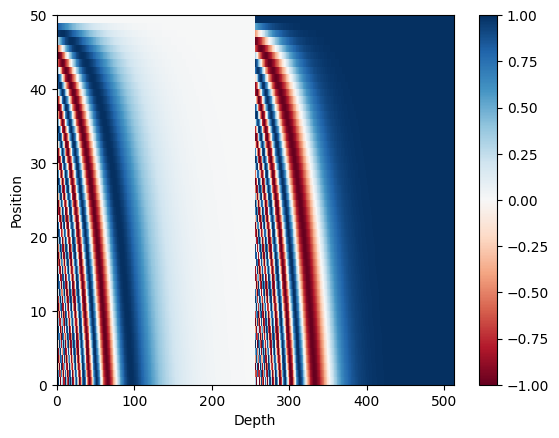

In [12]:
def plt_position_embedding(position_embedding):
    plt.pcolormesh(position_embedding[0,::-1,:], cmap='RdBu')
    plt.xlabel('Depth')
    plt.xlim((0, 512))
    plt.ylabel('Position')
    plt.colorbar()
    plt.show()
    
plt_position_embedding(position_embedding.numpy())

### 生成掩码mask


In [13]:
# 1. padding mask, 2. look ahead mask

def create_padding_mask(batch_data):
    """
    :param batch_data: [batch_size, seq_len]
    :return: [batch_size, 1, 1, seq_len]
    """
    padding_mask = tf.cast(tf.math.equal(batch_data, 0), dtype=tf.float32)
    return padding_mask[:, tf.newaxis, tf.newaxis, :]

# 测试
# 设置3x5矩阵，0都是padding，是零的得到的都是1，其他的都是零
x = tf.constant([[7, 6, 0, 0, 0], [1, 2, 3, 0, 0], [4,5, 0, 0,0]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 1.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[0., 0., 1., 1., 1.]]]], dtype=float32)>

In [14]:
# attention_weights.shape: [3,3]
# 第一个位置代表第一个单词和自己的attention，第二位置是第二个单词和第一个单词的attention
# 看不到后面的词刚好是下三角，使用库函数来实现
# [[1, 0, 0],
#  [4, 5, 0],
#  [7, 8, 9]]
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask # (seq_len, seq_len)

# 前面看不到后面的padding，矩阵下面全部为0
# 在mask里，应该被忽略的我们会设成1，应该被保留的会设成0，
# 而如果mask相应位置上为1，那么我们就给对应的logits 
# 加上一个超级小的负数， -1000000000， 这样对应的logits也就变成了一个超级小的数。
# 然后在计算softmax的时候，一个超级小的数的指数会无限接近与0。也就是它对应的attention的权重就是0了,
# 下面可以看到
create_look_ahead_mask(5)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]], dtype=float32)>

### 缩放点积注意力

In [15]:
# 参考原理文档，q是query，k，v代表k和value，q和k做完矩阵乘法后，做mask
# 缩放点积注意力，也叫自注意力

def scaled_dot_product_attention(q, k, v, mask):
    """
    Args:
    - q: shape == (..., seq_len_q, depth)
    - k: shape == (..., seq_len_k, depth)
    - v: shape == (..., seq_len_v, depth_v)
    - seq_len_k == seq_len_v  这两个是相等的
    - mask: shape == (..., seq_len_q, seq_len_k)
    Returns:
    - output: weighted sum
    - attention_weights: weights of attention
    """
    # 计算attentions时，我们只用了后两维在计算
    # transpose_b代表第二个矩阵是否做转置
    # matmul_qk.shape: (..., seq_len_q, seq_len_k)
    matmul_qk = tf.matmul(q, k, transpose_b = True)
    
    # 获得dk，dk是k最后一维的维度
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    # 根据文档公式，除以根号dk，维度为 （..., seq_len_q, seq_len_k）
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    # 将mask加入到scaled_attention_logits 
    if mask is not None:
        # 加了很大的负数，使得softmax后，mask的位置的值趋近于0
        scaled_attention_logits += (mask * -1e9)
        
    # softmax在最后一个轴（seq_len_k）上归一化，因此分数相加等于1
    # attention_weights.shape: (..., seq_len_q, seq_len_k)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis = -1)
    
    # output.shape: (..., seq_len_q, depth_v)
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

# 测试
def print_scaled_dot_product_attention(q, k, v):
    temp_out, temp_att = scaled_dot_product_attention(q, k, v, None)
    print("Attention weights are:")
    print(temp_att)
    print("Output is:")
    print(temp_out)
    

In [16]:
# 我们定义一个测试的Q，K，V
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32) # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32) # (4, 2)

temp_q1 = tf.constant([[0, 10, 0]], dtype=tf.float32) # (1, 3)

print_scaled_dot_product_attention(temp_q1, temp_k, temp_v)

Attention weights are:
tf.Tensor([[8.433274e-26 1.000000e+00 8.433274e-26 8.433274e-26]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[1.00000e+01 9.27448e-25]], shape=(1, 2), dtype=float32)


In [17]:
# 下面的作用是做四舍五入，让结果清爽
np.set_printoptions(suppress=True)
temp_q2 = tf.constant([[0, 0, 10]], dtype=tf.float32) # (1, 3)
#0.  0.  0.5 0.5 会和temp_v去做平均，因此得到的是550,5.5
print_scaled_dot_product_attention(temp_q2, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [18]:
temp_q3 = tf.constant([[10, 10, 0]], dtype=tf.float32) # (1, 3)
print_scaled_dot_product_attention(temp_q3, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [19]:
# 拼起来再来测试
temp_q4 = tf.constant([[0, 10, 0],
                       [0, 0, 10],
                       [10, 10, 0],
                       [10,0,10]], dtype=tf.float32) # (3, 3)
print_scaled_dot_product_attention(temp_q4, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.         1.         0.         0.        ]
 [0.         0.         0.5        0.5       ]
 [0.5        0.5        0.         0.        ]
 [0.33333334 0.         0.33333334 0.33333334]], shape=(4, 4), dtype=float32)
Output is:
tf.Tensor(
[[ 10.          0.       ]
 [550.          5.5      ]
 [  5.5         0.       ]
 [366.9104      3.6657715]], shape=(4, 2), dtype=float32)


### 多头注意力

In [20]:
# 多头注意力的实现
class MultiHeadAttention(keras.layers.Layer):
    """
    理论上:
    x -> Wq0 -> q0
    x -> Wk0 -> k0
    x -> Wv0 -> v0
    
    实战中:把三个概念区分开
    q -> Wq0 -> q0
    k -> Wk0 -> k0
    v -> Wv0 -> v0
    
    实战中技巧：q乘以W得到一个大的Q，然后分割为多个小q，拿每一个小q去做缩放点积
    q -> Wq -> Q -> split -> q0, q1, q2...
    """
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads  #分成几份,几头
        self.d_model = d_model
        assert self.d_model % self.num_heads == 0
        
        # 这里对应的大Q变小q怎么变，层次， self.depth代表每份的大小
        self.depth = self.d_model // self.num_heads
        # 神经元个数是512
        self.WQ = keras.layers.Dense(self.d_model)
        self.WK = keras.layers.Dense(self.d_model)
        self.WV = keras.layers.Dense(self.d_model)
        # 这里是拼接，拼接的输出是512，拼接后还要经过一个全连接层
        self.dense = keras.layers.Dense(self.d_model)
    
    def split_heads(self, x, batch_size):
        # x.shape: (batch_size, seq_len, d_model)
        # d_model = num_heads * depth
        #把x变为下面维度，用reshape
        #x--> (64,40,512)  (64,40,8,64) (batch_size, seq_len, num_heads, depth)
        x = tf.reshape(x,
                       (batch_size, -1, self.num_heads, self.depth))
        # 轴滚动后 x -> (batch_size, num_heads, seq_len, depth)
        return tf.transpose(x, perm=[0, 2, 1, 3])#轴滚动  (64,8,40,64)
    
    
    def call(self, q, k, v, mask):
        batch_size = tf.shape(q)[0] #形状的第0维就是batch_size
        #经过Q K V变化
        # print(q.shape)
        q = self.WQ(q) # q.shape: (batch_size, seq_len_q, d_model)
        k = self.WK(k) # k.shape: (batch_size, seq_len_k, d_model)
        v = self.WV(v) # v.shape: (batch_size, seq_len_v, d_model)
        # print('-'*50)
        # print(q.shape)  (64,8,40,64)
        # q.shape: (batch_size, num_heads, seq_len_q, depth)
        q = self.split_heads(q, batch_size)
        # k.shape: (batch_size, num_heads, seq_len_k, depth)
        k = self.split_heads(k, batch_size)
        # v.shape: (batch_size, num_heads, seq_len_v, depth)
        v = self.split_heads(v, batch_size)
    
        # 开始做缩放点积，得到的多头的信息存在在num_heads，depth上  (64,8,40,64)
        # scaled_attention_outputs.shape: (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape: (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention_outputs, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        # 这里做一下转置，让num_heads，depth在后面，为了还原成原来的形状
        # 在transpose之前，维度是(batch_size, num_heads, seq_len_v, depth)
        # scaled_attention_outputs.shape: (batch_size, seq_len_v, num_heads, depth)
        scaled_attention_outputs = tf.transpose(
            scaled_attention_outputs, perm = [0, 2, 1, 3])
        
        # 对计算出的8个缩放点积注意力进行合并
        # concat_attention.shape: (batch_size, seq_len_v, d_model)
        concat_attention = tf.reshape(scaled_attention_outputs,
                                      (batch_size, -1, self.d_model))
        
        #多头注意力计算完毕
        # output.shape : (batch_size, seq_len_v, d_model)
        output = self.dense(concat_attention)
        
        return output, attention_weights

temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
       
# 测试多头注意力
#创建一份虚拟数据
x = tf.random.uniform((1, 40, 256)) # (batch_size, seq_len_q, dim)
#开始计算，把y既当q，又当k，v
output, attn = temp_mha(x, x, x, mask = None)
print(output.shape)  #输出的尺寸，和x的尺寸一致
print(attn.shape)   #注意力的尺寸

(1, 40, 512)
(1, 8, 40, 40)


### 前馈网络

In [21]:
#定义我们的feed_forward_network，d_model节点数
def feed_forward_network(d_model, dff):
    # dff: dim of feed forward network.
    return keras.Sequential([
        keras.layers.Dense(dff, activation='relu'),
        keras.layers.Dense(d_model)
    ])

sample_ffn = feed_forward_network(512, 2048)
# 给一个输入测试
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder 层

In [22]:
class EncoderLayer(keras.layers.Layer):
    """
    x -> self attention -> add & normalize & dropout
      -> feed_forward -> add & normalize & dropout
    原理对应文档Add & Normalize 标题下的图
    """
    # d_model 给self attention和feed_forward_network，num_heads给self_attention用的
    # dff给feed_forward_network，rate是做dropout的
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = feed_forward_network(d_model, dff)
        
        self.layer_norm1 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        # epsilon 将epsilon加上方差以避免 除零问题
        self.layer_norm2 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        #下面两个层次用了做dropout，每次有10%的几率被drop掉
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        
    def call(self, x, training, encoder_padding_mask):
        # x.shape          : (batch_size, seq_len, dim=d_model)
        # attn_output.shape: (batch_size, seq_len, d_model)
        # out1.shape       : (batch_size, seq_len, d_model)
        #x作为q，k，v  原理对应文档Add & Normalize 标题下的图
        attn_output, _ = self.mha(x, x, x, encoder_padding_mask)
        attn_output = self.dropout1(attn_output, training=training) #预测时这里为False，预测时没有这层
        #dim=d_model 两个必须相等，这样x才可以和attn_output做加法
        out1 = self.layer_norm1(x + attn_output)
        
        # ffn_output.shape: (batch_size, seq_len, d_model)
        # out2.shape      : (batch_size, seq_len, d_model)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)#预测时这里为False，预测时没有这层
        out2 = self.layer_norm2(out1 + ffn_output)
        
        return out2
    
# 测试
sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_input = tf.random.uniform((64, 50, 512))  #因为做了残差连接，所以x的形状必须和mha输出形状一致
sample_output = sample_encoder_layer(sample_input, False, None)
print(sample_output.shape)


(64, 50, 512)


In [23]:
data = tf.constant(np.random.randint(0,5,(2,5)) * 5, dtype=tf.float32)
print(data)

tf.Tensor(
[[ 0.  5. 15. 10.  5.]
 [ 0. 20. 15. 10. 15.]], shape=(2, 5), dtype=float32)


In [ ]:
layer = tf.keras.layers.LayerNormalization()
output = layer(data)
print(output)

In [ ]:
m = np.mean(data, axis=1)
s = np.std(data, axis=1)
print(m, s)
res = (data - m[:, np.newaxis]) / s[:, np.newaxis]
print(res)

In [ ]:
sample_encoder_layer.variables
sample_encoder_layer.trainable_variables

## Decoder 层

In [24]:
class DecoderLayer(keras.layers.Layer):
    """
    x -> self attention -> add & normalize & dropout -> out1
    out1 , encoding_outputs -> attention -> add & normalize & dropout -> out2
    out2 -> ffn -> add & normalize & dropout -> out3
    """
    def __init__(self, d_model, num_heads, dff, rate = 0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = feed_forward_network(d_model, dff)
        #因为有两个attention，还有一个feed_forward_network，所以有3个
        #LayerNormalization和3个dropout
        self.layer_norm1 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        self.layer_norm3 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)
        
    def call(self, x, encoding_outputs, training,
             decoder_mask, encoder_decoder_padding_mask):
        # decoder_mask: 由look_ahead_mask和decoder_padding_mask合并而来
        
        # x.shape: (batch_size, target_seq_len, d_model)
        # encoding_outputs.shape: (batch_size, input_seq_len, d_model)
        
        #按照上面类的注释的步骤依次来编写call实现
        # attn1, out1.shape : (batch_size, target_seq_len, d_model)
        attn1, attn_weights1 = self.mha1(x, x, x, decoder_mask)
        attn1 = self.dropout1(attn1, training = training)
        out1 = self.layer_norm1(attn1 + x)
        
        # attn2, out2.shape : (batch_size, target_seq_len, d_model)
        attn2, attn_weights2 = self.mha2(
            out1, encoding_outputs, encoding_outputs,
            encoder_decoder_padding_mask)
        attn2 = self.dropout2(attn2, training = training) #qttn2和out1尺寸一致，和q的尺寸一致
        out2 = self.layer_norm2(attn2 + out1)  
        
        # ffn_output, out3.shape: (batch_size, target_seq_len, d_model)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layer_norm3(ffn_output + out2)
        
        return out3, attn_weights1, attn_weights2
    
# 测试
sample_decoder_layer = DecoderLayer(512, 8, 2048)
sample_decoder_input = tf.random.uniform((64, 60, 512))
sample_decoder_output, sample_decoder_attn_weights1, sample_decoder_attn_weights2 = sample_decoder_layer(
    sample_decoder_input, sample_output, False, None, None)

print(sample_decoder_output.shape)
print(sample_decoder_attn_weights1.shape)  #最后一维60是和x的维度一致的
print(sample_decoder_attn_weights2.shape) #最后一维60是和x的维度相关的

(64, 60, 512)
(64, 8, 60, 60)
(64, 8, 60, 50)


## EncoderModel

In [25]:
class EncoderModel(keras.layers.Layer):
    def __init__(self, num_layers, input_vocab_size, max_length,
                 d_model, num_heads, dff, rate=0.1):
        super(EncoderModel, self).__init__()
        self.d_model = d_model
        # 这是layers数目
        self.num_layers = num_layers
        self.max_length = max_length
        
        # 构建embedding层
        self.embedding = keras.layers.Embedding(input_vocab_size,
                                                self.d_model)
        # position_embedding.shape: (1, max_length, d_model)
        self.position_embedding = get_position_embedding(max_length,
                                                         self.d_model)
        
        self.dropout = keras.layers.Dropout(rate)
        self.encoder_layers = [
            EncoderLayer(d_model, num_heads, dff, rate)
            for _ in range(self.num_layers)]
        
    
    def call(self, x, training, encoder_padding_mask):
        # x.shape: (batch_size, input_seq_len)
        input_seq_len = tf.shape(x)[1]
        tf.debugging.assert_less_equal(
            input_seq_len, self.max_length,
            "input_seq_len should be less or equal to self.max_length")
        
        # x.shape: (batch_size, input_seq_len, d_model)
        x = self.embedding(x)
        #x做缩放，是值在0到d_model之间
        # 这个缩放的目的是为了防止在自注意力计算中出现梯度消失或梯度爆炸的问题
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # 因为x长度比position_embedding可能要小，因此embedding切片后和x相加
        # position_embedding的轴0的size是1，在x的轴零维度广播相加
        x += self.position_embedding[:, :input_seq_len, :]
        
        x = self.dropout(x, training = training) #在进入encoderLayer之前进行dropout，防止过拟合
        
        #得到的x不断作为下一层的输入
        for i in range(self.num_layers):
            x = self.encoder_layers[i](x, training,
                                       encoder_padding_mask)
        # x最终shape如下
        # x.shape: (batch_size, input_seq_len, d_model)
        return x
    
# 测试
sample_encoder_model = EncoderModel(2, 8500, max_length,
                                    512, 8, 2048)
sample_encoder_model_input = tf.random.uniform((64, 37))
sample_encoder_model_output = sample_encoder_model(
    sample_encoder_model_input, False, encoder_padding_mask = None)
print(sample_encoder_model_output.shape)

(64, 37, 512)


## DecoderModel

In [26]:
class DecoderModel(keras.layers.Layer):
    def __init__(self, num_layers, target_vocab_size, max_length,
                 d_model, num_heads, dff, rate=0.1):
        super(DecoderModel, self).__init__()
        self.num_layers = num_layers #有多少个decoder Layer
        self.max_length = max_length
        self.d_model = d_model
        
        self.embedding = keras.layers.Embedding(target_vocab_size,
                                                d_model)
        self.position_embedding = get_position_embedding(max_length,
                                                         d_model)
        
        self.dropout = keras.layers.Dropout(rate)
        self.decoder_layers = [
            DecoderLayer(d_model, num_heads, dff, rate)
            for _ in range(self.num_layers)]
        
    def call(self, x, encoding_outputs, training,
             decoder_mask, encoder_decoder_padding_mask):
        # x.shape: (batch_size, output_seq_len)
        output_seq_len = tf.shape(x)[1]
        # 如果要输出的商都超出了max_length，就报错
        tf.debugging.assert_less_equal(
            output_seq_len, self.max_length,
            "output_seq_len should be less or equal to self.max_length")
        
        #a ttention_weights都是由decoder layer返回，把它保存下来
        attention_weights = {}
        
        # x.shape: (batch_size, output_seq_len, d_model)
        x = self.embedding(x)
        #缩放
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.position_embedding[:, :output_seq_len, :]
        
        x = self.dropout(x, training = training)
        
        for i in range(self.num_layers):
            # attn1,attn2分别是两个attention
            x, attn1, attn2 = self.decoder_layers[i](
                x, encoding_outputs, training,
                decoder_mask, encoder_decoder_padding_mask)
            attention_weights[
                'decoder_layer{}_att1'.format(i+1)] = attn1
            attention_weights[
                'decoder_layer{}_att2'.format(i+1)] = attn2
        # x.shape: (batch_size, output_seq_len, d_model),attention_weights是为了画图
        return x, attention_weights

 
sample_decoder_model = DecoderModel(2, 8000, max_length,
                                    512, 8, 2048)  
  
 # 测试
sample_decoder_model_input = tf.random.uniform((64, 35))
sample_decoder_model_output, sample_decoder_model_att = sample_decoder_model(
    sample_decoder_model_input,
    sample_encoder_model_output,#注意这里是encoder的output
    training = False, decoder_mask = None,
    encoder_decoder_padding_mask = None)

print(sample_decoder_model_output.shape)


(64, 35, 512)


## Transformer

In [27]:
class Transformer(keras.Model):
    def __init__(self, num_layers, input_vocab_size, target_vocab_size,
                 max_length, d_model, num_heads, dff, rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder_model = EncoderModel(
            num_layers, input_vocab_size, max_length,
            d_model, num_heads, dff, rate)
        
        self.decoder_model = DecoderModel(
            num_layers, target_vocab_size, max_length,
            d_model, num_heads, dff, rate)
        
        self.final_layer = keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, encoder_padding_mask,
             decoder_mask, encoder_decoder_padding_mask):
        # encoding_outputs.shape: (batch_size, input_seq_len, d_model)
        encoding_outputs = self.encoder_model(
            inp, training, encoder_padding_mask)
        
        # decoding_outputs.shape: (batch_size, output_seq_len, d_model)
        decoding_outputs, attention_weights = self.decoder_model(
            tar, encoding_outputs, training,
            decoder_mask, encoder_decoder_padding_mask)
        
        # predictions.shape: (batch_size, output_seq_len, target_vocab_size)
        predictions = self.final_layer(decoding_outputs)
        
        return predictions, attention_weights
    

# 测试
sample_transformer = Transformer(4, pt_tokenizer.vocab_size + 2, en_tokenizer.vocab_size + 2, max_length,
                                 128, 8, 512, rate = 0.1)
temp_input = tf.random.uniform((64, 26))
temp_target = tf.random.uniform((64, 31))

# 得到输出
predictions, attention_weights = sample_transformer(
    temp_input, temp_target, training = False,
    encoder_padding_mask = None,
    decoder_mask = None,
    encoder_decoder_padding_mask = None)
# 输出shape
print(predictions.shape)
print('-'*50)
# attention_weights 的shape打印，为了后面画图做铺垫
for key in attention_weights:
    print(key, attention_weights[key].shape)
print('-'*50)
sample_transformer.summary()        


(64, 31, 8089)
--------------------------------------------------
decoder_layer1_att1 (64, 8, 31, 31)
decoder_layer1_att2 (64, 8, 31, 26)
decoder_layer2_att1 (64, 8, 31, 31)
decoder_layer2_att2 (64, 8, 31, 26)
decoder_layer3_att1 (64, 8, 31, 31)
decoder_layer3_att2 (64, 8, 31, 26)
decoder_layer4_att1 (64, 8, 31, 31)
decoder_layer4_att2 (64, 8, 31, 26)
--------------------------------------------------
Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_model_1 (EncoderMod  multiple                 1844736   
 el)                                                             
                                                                 
 decoder_model_1 (DecoderMod  multiple                 2093696   
 el)                                                             
                                                                 
 dense_128 (Dense)           multiple         

In [28]:
#超参数
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
#加2是因为最后两个位置是start和end
input_vocab_size = pt_tokenizer.vocab_size + 2
target_vocab_size = en_tokenizer.vocab_size + 2

dropout_rate = 0.1

transformer = Transformer(num_layers,
                          input_vocab_size,
                          target_vocab_size,
                          max_length,
                          d_model, num_heads, dff, dropout_rate)

### 学习率变化，warm up

In [29]:
# 学习率变化，是先增后减，因为前期可以快点，后期模型比较好，就要慢点
# lrate = (d_model ** -0.5) * min(step_num ** (-0.5),
#                                 step_num * warm_up_steps **(-1.5))
# 自定义的学习率调整设计实现
# 这里的公式看这里 https://tensorflow.google.cn/tutorials/text/transformer
class CustomizedSchedule(
    keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps = 4000):
        super().__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step=tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** (-1.5))
        
        arg3 = tf.math.rsqrt(self.d_model)
        
        return arg3 * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomizedSchedule(d_model)
# 优化器每次会调用learning_rate对，把step传给它，得到学习率的值
optimizer = keras.optimizers.Adam(learning_rate,
                                  beta_1 = 0.9,
                                  beta_2 = 0.98,
                                  epsilon = 1e-9)

Text(0.5, 0, 'Train step')

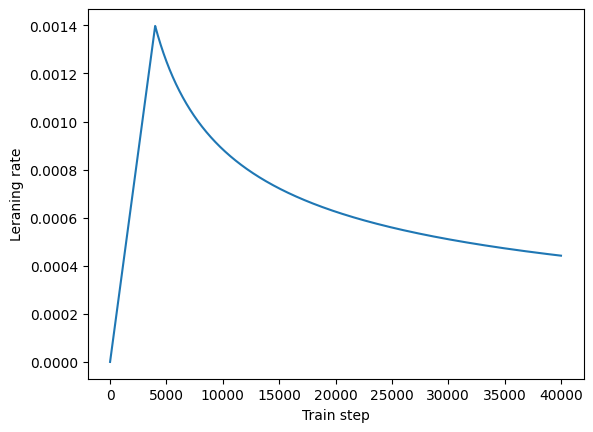

In [30]:
temp_learning_rate_schedule = CustomizedSchedule(d_model)
# 下面是学习率的设计图
plt.plot(
    temp_learning_rate_schedule(
        tf.range(40000, dtype=tf.float32)))
plt.ylabel("Leraning rate")
plt.xlabel("Train step")

In [31]:
loss_object = keras.losses.SparseCategoricalCrossentropy(
    from_logits = True)

# 下面是损失的padd
def loss_function(real, pred):
    # 损失做了掩码处理，是padding的地方不计算损失
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

### 初始化mask

In [32]:
def create_masks(inp, tar):
    """
    Encoder:
      - encoder_padding_mask (self attention of EncoderLayer)
      对于encoder中padding值没作用，所以无需attention
    Decoder:
      - look_ahead_mask (self attention of DecoderLayer)
      target位置上的词不能看到之后的词，因为之后的词没预测出来
      - encoder_decoder_padding_mask (encoder-decoder attention of DecoderLayer)
      decoder不应该到encoder的padding上去花费精力
      - decoder_padding_mask (self attention of DecoderLayer)
      decoder也有padding，所以mask掉
    """
    # inp的shape (64,37)
    # tar的shape (64,40)
    encoder_padding_mask = create_padding_mask(inp)
    encoder_decoder_padding_mask = create_padding_mask(inp)
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1]) #上三角矩阵 (40,40)
    decoder_padding_mask = create_padding_mask(tar) #tar的padding mask (64,1,1,40)
    decoder_mask = tf.maximum(decoder_padding_mask,
                              look_ahead_mask)
    
    # print( encoder_padding_mask.shape ) #这里看完要注释掉，避免下面太多打印
    # print( encoder_decoder_padding_mask.shape )
    # print( look_ahead_mask.shape)
    # print('-'*50)
    # print( decoder_padding_mask.shape)
    # print('-'*50)
    # print( decoder_mask.shape)

    
    return encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask

In [33]:
# 测试
temp_inp, temp_tar = iter(train_dataset.take(1)).next()
print(temp_inp.shape)
print(temp_tar.shape)
create_masks(temp_inp, temp_tar)
#样本大小是64，不足的补齐35，或者39
#最后是(64, 1, 39, 39)原因是既不关注前面的padding，也不关注后面的单词

(64, 40)
(64, 40)


(<tf.Tensor: shape=(64, 1, 1, 40), dtype=float32, numpy=
 array([[[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        ...,
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)>,
 <tf.Tensor: shape=(64, 1, 40, 40), dtype=float32, numpy=
 array([[[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 1., 1., ..., 1., 1., 1.

## 模型训练

In [34]:
checkpoint_dir = './checkpoints'
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                  transformer=transformer) # 监控的对象

In [35]:
train_loss = keras.metrics.Mean(name = 'train_loss') #累计求batch平均损失
train_accuracy = keras.metrics.SparseCategoricalAccuracy(
    name = 'train_accuracy')

# 原始的标签是这样的 <start>  I  hava a bag <end>

# Decoder input   <start>  I  hava a bag
# Decoder output  I  hava a bag <end>

@tf.function
def train_step(inp, tar):
    tar_inp  = tar[:, :-1]  # 没带end decoder 模块的输入
    tar_real = tar[:, 1:]   # 没有start  decoder模块的输出

    encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask \
    = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, True,
                                     encoder_padding_mask,
                                     decoder_mask,
                                     encoder_decoder_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(
        zip(gradients, transformer.trainable_variables))
    train_loss(loss) # 损失，具有累计效果
    train_accuracy(tar_real, predictions) #准确率，具有累计效果


In [36]:
#如果加载成功，是<tensorflow.python.checkpoint.checkpoint.CheckpointLoadStatus，不成功有init
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [37]:
# # 一个epochs接近100多秒，在kaggle上
# epochs = 20
# for epoch in range(epochs):
#     start = time.time()
#     # reset后就会从零开始累计
#     train_loss.reset_states()
#     train_accuracy.reset_states()
#     
#     for (batch, (inp, tar)) in enumerate(train_dataset):
#         train_step(inp, tar)
#         if batch % 100 == 0:
#             print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
#                 epoch + 1, batch, train_loss.result(),
#                 train_accuracy.result()))
#     
#     print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(
#         epoch + 1, train_loss.result(), train_accuracy.result()))
#     print('Time take for 1 epoch: {} secs\n'.format(
#         time.time() - start))

# loss是一个正常的指标，accuracy只是机器翻译的一个参考指标，可以看趋势
    

In [38]:
"""
eg: A B C D E F G H.
Train: A B C D, E F G 
Eval:  A-》B
     A B-->C
     A B C-->D
类似seq2seq2
不同的是 transformer可以并行的处理，前后没有依赖，而seq2seq前后有依赖
"""
def evaluate(inp_sentence):
    #文本的句子转换为id的句子
    input_id_sentence = [pt_tokenizer.vocab_size] \
    + pt_tokenizer.encode(inp_sentence) + [pt_tokenizer.vocab_size + 1]
    #transformer转换是两维的，因此转换
    # encoder_input.shape: (1, input_sentence_length)
    encoder_input = tf.expand_dims(input_id_sentence, 0)
    
    # decoder_input.shape: (1, 1)
    #我们预测一个词就放入decoder_input，decoder_input给多个就可以预测多个，我们给一个
    decoder_input = tf.expand_dims([en_tokenizer.vocab_size], 0)  #做一个<start>传进去，去预测i
    
    for i in range(max_length):
        #产生mask并传给transformer
        encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask \
        = create_masks(encoder_input, decoder_input)
        # predictions.shape: (batch_size, output_target_len, target_vocab_size)
        predictions, attention_weights = transformer(
            encoder_input,
            decoder_input,
            False,
            encoder_padding_mask,
            decoder_mask,
            encoder_decoder_padding_mask)
        # predictions.shape: (batch_size, target_vocab_size)
        #我们每次只预测一个，所以是最后一个，第三个维度是vocab_size维度
        print(predictions.shape)
        predictions = predictions[:, -1, :]
        #预测值就是概率最大的那个的索引，那最后一个维度中最大的那个值
        predicted_id = tf.cast(tf.argmax(predictions, axis = -1),
                               tf.int32)
        #如果等于end token id，预测结束
        if tf.equal(predicted_id, en_tokenizer.vocab_size + 1):
            return tf.squeeze(decoder_input, axis = 0), attention_weights
        #如果predicted_id不是end id，添加到新的decoder_input中
        decoder_input = tf.concat([decoder_input, [predicted_id]],
                                  axis = -1)
        # print(decoder_input)
    return tf.squeeze(decoder_input, axis = 0), attention_weights
        
        

In [39]:
def plot_encoder_decoder_attention(attention, input_sentence,
                                   result, layer_name):
    fig = plt.figure(figsize = (16, 8))
    
    input_id_sentence = pt_tokenizer.encode(input_sentence)
    
    # attention.shape: (num_heads, tar_len, input_len)
    attention = tf.squeeze(attention[layer_name], axis = 0)
    
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head + 1)
        
        ax.matshow(attention[head][:-1, :])
        
        fontdict = {'fontsize': 10}
        
        ax.set_xticks(range(len(input_id_sentence) + 2))
        ax.set_yticks(range(len(result)))
        
        ax.set_ylim(len(result) - 1.5, -0.5)
        
        ax.set_xticklabels(
            ['<start>'] + [pt_tokenizer.decode([i]) for i in input_id_sentence] + ['<end>'],
            fontdict = fontdict, rotation = 90)
        ax.set_yticklabels(
            [en_tokenizer.decode([i]) for i in result if i < en_tokenizer.vocab_size],
            fontdict = fontdict)
        ax.set_xlabel('Head {}'.format(head + 1))
    plt.tight_layout()
    plt.show()
    

In [40]:
def translate(input_sentence, layer_name = ''):
    result, attention_weights = evaluate(input_sentence)
    
    predicted_sentence = en_tokenizer.decode(
        [i for i in result if i < en_tokenizer.vocab_size])
    
    print("Input: {}".format(input_sentence))
    print("Predicted translation: {}".format(predicted_sentence))
    
    if layer_name:
        plot_encoder_decoder_attention(attention_weights, input_sentence,
                                       result, layer_name)

In [41]:
translate('está muito frio aqui.')

(1, 1, 8089)
(1, 2, 8089)
(1, 3, 8089)
(1, 4, 8089)
(1, 5, 8089)
(1, 6, 8089)
(1, 7, 8089)
(1, 8, 8089)
(1, 9, 8089)
(1, 10, 8089)
(1, 11, 8089)
(1, 12, 8089)
(1, 13, 8089)
(1, 14, 8089)
(1, 15, 8089)
Input: está muito frio aqui.
Predicted translation: it 's very interesting now , there 's the same thing .


In [42]:
translate('isto é minha vida')

(1, 1, 8089)
(1, 2, 8089)
(1, 3, 8089)
(1, 4, 8089)
(1, 5, 8089)
(1, 6, 8089)
Input: isto é minha vida
Predicted translation: this is my life .


In [44]:
from nltk.translate.bleu_score import sentence_bleu
total_bleu = 0.0
i = 0
for pt_val, en_val in val_examples:
    if len(pt_tokenizer.encode(pt_val.numpy())) > 38 or len(en_tokenizer.encode(en_val.numpy())) > 38:
        continue
    result, _ = evaluate(pt_val.numpy())
    predicted_sentence = en_tokenizer.decode([i for i in result
                                              if i < en_tokenizer.vocab_size])
    bleu = sentence_bleu(
        [en_val.numpy().decode('utf8').split(' ')],
        predicted_sentence.split(' '),
        weights=(0.5, 0.5, 0., 0.)) # weights是四个指标的权重，即1-gram,2-gram,3-gram,4-gram
    total_bleu += bleu
    i+=1
    if i==100:
        break
total_bleu/i

(1, 1, 8089)
(1, 2, 8089)
(1, 3, 8089)
(1, 4, 8089)
(1, 5, 8089)
(1, 6, 8089)
(1, 7, 8089)
(1, 8, 8089)
(1, 9, 8089)
(1, 10, 8089)
(1, 11, 8089)
(1, 1, 8089)


C:\Users\83633\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\83633\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\83633\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lowe

(1, 2, 8089)
(1, 3, 8089)
(1, 4, 8089)
(1, 5, 8089)
(1, 6, 8089)
(1, 7, 8089)
(1, 8, 8089)
(1, 9, 8089)
(1, 10, 8089)
(1, 11, 8089)
(1, 12, 8089)
(1, 13, 8089)
(1, 14, 8089)
(1, 15, 8089)
(1, 16, 8089)
(1, 17, 8089)
(1, 18, 8089)
(1, 19, 8089)
(1, 20, 8089)
(1, 21, 8089)
(1, 1, 8089)
(1, 2, 8089)
(1, 3, 8089)
(1, 4, 8089)
(1, 5, 8089)
(1, 6, 8089)
(1, 7, 8089)
(1, 8, 8089)
(1, 9, 8089)
(1, 10, 8089)
(1, 11, 8089)
(1, 12, 8089)
(1, 13, 8089)
(1, 14, 8089)
(1, 15, 8089)
(1, 16, 8089)
(1, 17, 8089)
(1, 18, 8089)
(1, 19, 8089)
(1, 20, 8089)
(1, 21, 8089)
(1, 22, 8089)
(1, 23, 8089)
(1, 1, 8089)
(1, 2, 8089)
(1, 3, 8089)
(1, 4, 8089)
(1, 5, 8089)
(1, 6, 8089)
(1, 7, 8089)
(1, 8, 8089)
(1, 9, 8089)
(1, 10, 8089)
(1, 11, 8089)
(1, 1, 8089)
(1, 2, 8089)
(1, 3, 8089)
(1, 4, 8089)
(1, 5, 8089)
(1, 6, 8089)
(1, 7, 8089)
(1, 8, 8089)
(1, 9, 8089)
(1, 10, 8089)
(1, 11, 8089)
(1, 12, 8089)
(1, 1, 8089)
(1, 2, 8089)
(1, 3, 8089)
(1, 4, 8089)
(1, 5, 8089)
(1, 6, 8089)
(1, 7, 8089)
(1, 8, 8089)
(1, 9, 

0.008361719186432779